# PRISME — Exploration du RAW

Ce notebook explore les données **RAW** générées par la pipeline ETL.

- **RAW** : données brutes depuis yfinance (CSV prix + JSON infos)
- **INTERIM** : données transformées (timezone retirée)
- **PROCESSED** : données nettoyées et prêtes (Parquet)

In [ ]:
import json
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

# Chemins : depuis src/notebooks/, on remonte de 2 niveaux pour arriver à la racine
ROOT = Path.cwd().resolve().parent.parent
RAW_DIR = ROOT / "data" / "raw"
CONFIG_PATH = ROOT / "products_config.json"

print(f"Racine du projet: {ROOT}")
print(f"Dossier RAW: {RAW_DIR}")
print(f"Config: {CONFIG_PATH}")


(PosixPath('/home/calvotom/Developpement/Prisme/src'),
 PosixPath('/home/calvotom/Developpement/Prisme/src/data/raw'),
 PosixPath('/home/calvotom/Developpement/Prisme/src/products_config.json'))

In [ ]:
# Chargement de l'univers de produits (nom -> ticker)
with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    products = json.load(f)

universe = {name: meta["ticker"] for name, meta in products.items()}
print(f"Produits chargés: {len(universe)}")
universe


FileNotFoundError: Config introuvable: /home/calvotom/Developpement/Prisme/src/products_config.json

In [3]:
# Lecture des fichiers RAW (prix)
price_dfs: dict[str, pd.DataFrame] = {}

for name in universe.keys():
    p = RAW_DIR / f"{name}_raw_prices.csv"
    df = pd.read_csv(p)

    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.set_index("Date").sort_index()
    price_dfs[name] = df

summary = pd.DataFrame(
    {
        "rows": {k: len(v) for k, v in price_dfs.items()},
        "start": {k: v.index.min() for k, v in price_dfs.items()},
        "end": {k: v.index.max() for k, v in price_dfs.items()},
        "cols": {k: list(v.columns) for k, v in price_dfs.items()},
    }
)
summary


NameError: name 'universe' is not defined

## Prix de clôture

On trace les séries de **Close** pour comparer les tendances.


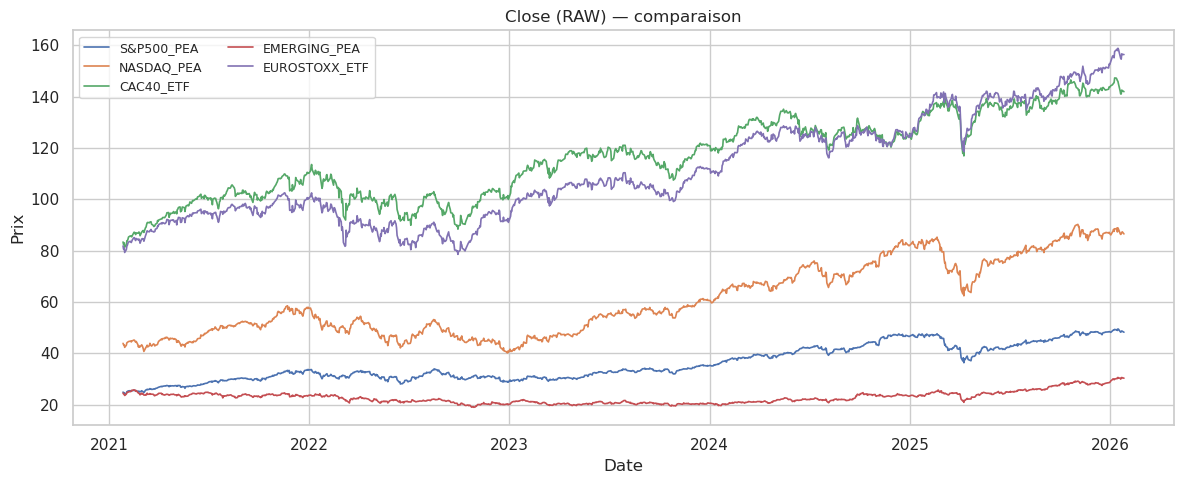

In [6]:
plt.figure()
for name, df in price_dfs.items():
    if "Close" in df.columns:
        plt.plot(df.index, df["Close"], label=name, linewidth=1.2)

plt.title("Close (RAW) — comparaison")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


## Rendements journaliers + corrélation

On calcule les rendements journaliers sur `Close` et on regarde :
- la distribution
- la corrélation entre produits


In [7]:
# Série de rendements (Close)
returns = {}
for name, df in price_dfs.items():
    if "Close" in df.columns:
        r = df["Close"].pct_change().dropna()
        returns[name] = r

ret_df = pd.DataFrame(returns).dropna(how="all")
ret_df.tail()


,S&P500_PEA,NASDAQ_PEA,CAC40_ETF,EMERGING_PEA,EUROSTOXX_ETF
Date,,,,,
2026-01-20 00:00:00+01:00,-0.006667,-0.004495,-0.008433,-0.011630,-0.005134
2026-01-21 00:00:00+01:00,0.003625,0.002316,0.000000,0.012500,-0.002322
2026-01-22 00:00:00+01:00,0.006666,0.007046,0.010631,0.008329,0.013449
2026-01-23 00:00:00+01:00,-0.002973,0.002294,-0.001262,-0.004212,-0.001531
2026-01-26 00:00:00+01:00,-0.007300,-0.009270,-0.002949,-0.004426,-0.000256


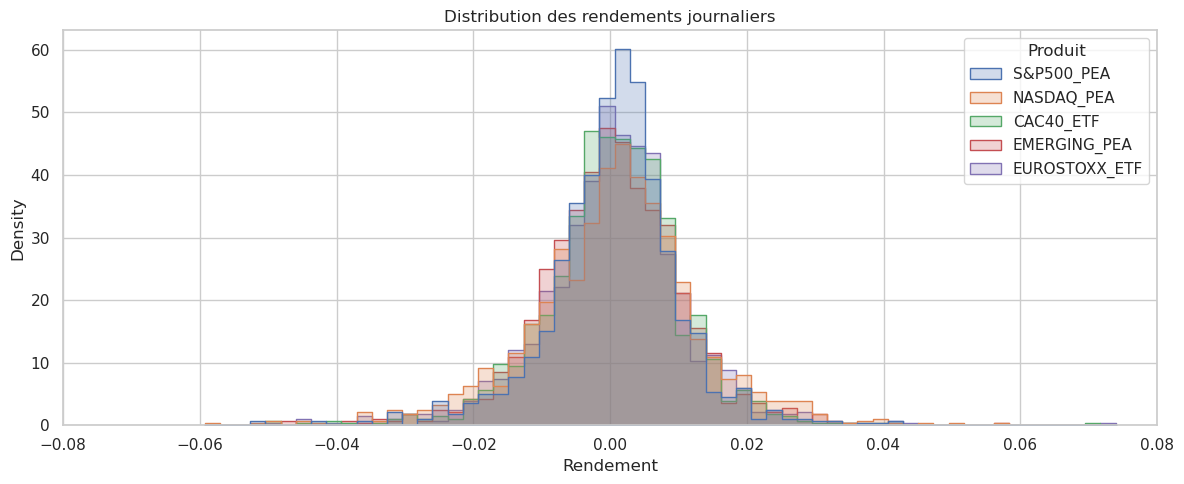

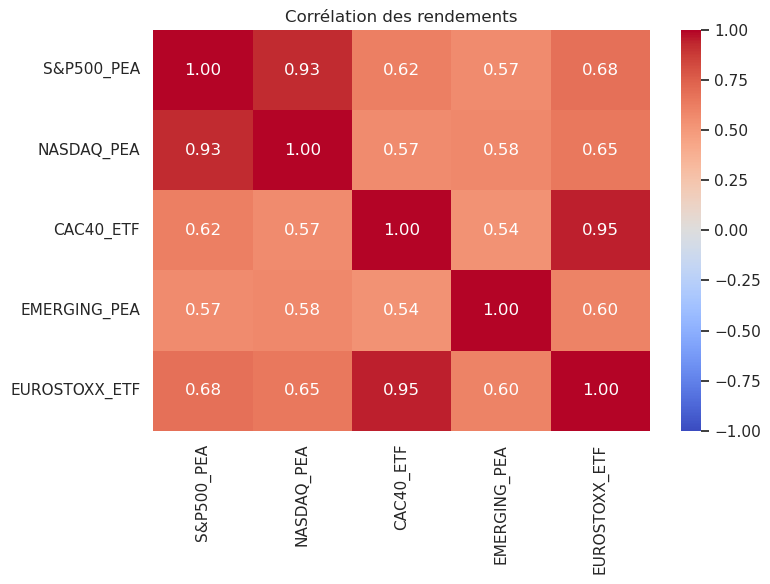

In [ ]:
# Distribution des rendements
melted = ret_df.melt(var_name="Produit", value_name="Rendement")
plt.figure(figsize=(12, 5))
sns.histplot(melted, x="Rendement", hue="Produit", element="step", stat="density", common_norm=False, bins=60)
plt.title("Distribution des rendements journaliers")
plt.xlim(-0.08, 0.08)
plt.tight_layout()
plt.show()

# Matrice de corrélation
corr = ret_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Corrélation des rendements")
plt.tight_layout()
plt.show()


## Infos RAW (JSON)

On regarde rapidement quelques champs clés disponibles dans les fichiers `*_raw_infos.json`.


In [12]:
# lecture des infos RAW
info_rows = []
keys_focus = [
    "symbol",
    "shortName",
    "longName",
    "currency",
    "fundFamily",
    "legalType",
    "regularMarketPrice",
    "navPrice",
    "netAssets",
    "ytdReturn",
]

for name in universe.keys():
    p = RAW_DIR / f"{name}_raw_infos.json"
    if not p.exists():
        continue
    info = json.loads(p.read_text(encoding="utf-8"))
    row = {"product": name}
    for k in keys_focus:
        row[k] = info.get(k)
    info_rows.append(row)

pd.DataFrame(info_rows)


,product,symbol,shortName,longName,currency,fundFamily,legalType,regularMarketPrice,navPrice,netAssets,ytdReturn
0,S&P500_PEA,PE500.PA,Amundi PEA S&P 500 Screened UCI,Amundi PEA S&P 500 Screened UCITS ETF - Acc,EUR,Amundi Asset Management,Exchange Traded Fund,48.274,48.7177,1.100197e+09,3.72467
1,NASDAQ_PEA,PUST.PA,Amundi PEA Nasdaq-100 UCITS ETF,Amundi PEA Nasdaq-100 UCITS ETF Acc,EUR,Amundi Asset Management,Exchange Traded Fund,86.570,87.2235,8.854732e+08,6.00786
2,CAC40_ETF,C40.PA,AMUNDI CAC 40 ESG UCITS ETF Acc,Amundi Index Solutions - AMUNDI CAC 40 ESG UCI...,EUR,Amundi Luxembourg S.A.,Exchange Traded Fund,142.000,142.6413,6.614975e+08,14.60036
3,EMERGING_PEA,PAEEM.PA,Amundi PEA Emergent (MSCI Emerg,Amundi PEA Emergent (MSCI Emerging) ESG Transi...,EUR,Amundi Asset Management,Exchange Traded Fund,30.364,30.2487,4.310591e+08,21.03640
4,EUROSTOXX_ETF,C50.PA,Amundi Core EURO STOXX 50 UCITS,Amundi Core EURO STOXX 50 UCITS ETF EUR Acc,EUR,Amundi Luxembourg S.A.,Exchange Traded Fund,156.460,156.4468,NaN,21.80027


In [11]:
# tableau de synthèse par produit 
stats = pd.DataFrame(index=ret_df.columns)
stats["mean_daily_return"] = ret_df.mean()
stats["vol_daily"] = ret_df.std()
stats["vol_annual"] = stats["vol_daily"] * (252 ** 0.5)
stats["min_return"] = ret_df.min()
stats["max_return"] = ret_df.max()

stats.sort_values("vol_annual", ascending=True)


,mean_daily_return,vol_daily,vol_annual,min_return,max_return
S&P500_PEA,0.000563,0.009672,0.153540,-0.052008,0.042504
CAC40_ETF,0.000468,0.010286,0.163293,-0.048892,0.070349
EMERGING_PEA,0.000219,0.010291,0.163357,-0.047053,0.058179
EUROSTOXX_ETF,0.000563,0.010692,0.169726,-0.049229,0.073938
NASDAQ_PEA,0.000609,0.012605,0.200105,-0.059296,0.058042


## Groupes dans la population du dataset

Dans ce dataset, chaque observation est un **jour de cotation** pour un des 5 ETF. On peut distinguer 3 grands groupes de produits :

- **Groupe US actions large cap** : `S&P500_PEA`, `NASDAQ_PEA` (exposition aux actions US)
- **Groupe Europe** : `CAC40_ETF`, `EUROSTOXX_ETF` (France vs zone euro élargie)
- **Groupe émergents** : `EMERGING_PEA` (pays émergents)

En termes de “population”, la **majorité** du dataset représente des actions de pays développés (US + Europe), et une **minorité** correspond aux marchés émergents (`EMERGING_PEA`). Les stats de volatilité (`vol_annual`) permettent de voir que certains profils sont plus risqués que d’autres.


## Problèmes potentiels à analyser

En regardant les courbes de **Close**, la heatmap de **corrélation** et le tableau `stats` :

- Les produits sont **très corrélés entre eux** (actions mondiales de grandes capitalisations), ce qui pose un problème de **diversification réelle**.
- Le groupe US et le groupe Europe peuvent avoir des niveaux de **volatilité** proches : le risque n’est pas uniformément réparti.
- Le dataset est **centré sur une seule classe d’actifs** (ETF actions), sans obligations / monétaire / immobilier.

Ce sont donc des **axes de questionnement** : concentration géographique (US/Europe), concentration par classe d’actifs, corrélation forte entre plusieurs ETF.


## Pistes de solutions

À partir de ces constats, quelques idées d’amélioration du dataset / portefeuille :

- **Ajouter d’autres classes d’actifs** : ETF obligations, monétaire, immobilier, matières premières → réduire la corrélation globale.
- **Équilibrer les expositions géographiques** : renforcer ou ajouter d’autres zones (Asie développée, Amérique latine, etc.).
- **Introduire des profils plus défensifs** (volatilité plus faible dans `stats`) pour lisser les drawdowns.
- Pour l’ETL : enrichir le RAW avec d’autres variables (facteurs macro, indicateurs de risque) pour des analyses plus fines.


## Ce qu’on peut tirer de ce dataset

En combinant **courbes de prix**, **rendements**, **corrélation** et **infos RAW JSON**, ce dataset permet :

- De comparer les **profils de risque/rendement** de plusieurs grands ETF actions (US, Europe, émergents).
- De visualiser si un portefeuille est **trop concentré** sur certaines zones ou certains indices.
- De construire des **indicateurs simples** (volatilité annualisée, drawdowns, corrélations) comme base d’un dashboard d’allocation.

Ce n’est pas encore un dataset “complet” pour toute la finance, mais c’est une **bonne base structurée** pour explorer la performance de quelques ETF PEA éligibles et réfléchir à la diversification.
